# Final Task Group 1 - Implementing A3C
### Tom Pries, Philipp Hummel, Jonas Kraasch
- with help from this tutorial: https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-8-asynchronous-actor-critic-agents-a3c-c88f72a5e9f2

In [1]:
#Import Packages

import tensorflow as tf
import numpy as np
import gym
import threading 
import scipy.signal
import multiprocessing
from time import sleep
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

## Helper Classes for building and executing the Network

In [2]:
#Adapted From Lukas Braun
def feed_forward_layer(x, target_size, activation_function = None):
    print("Forward-Layer:" + str(x.shape))
    
    fan_in = int(x.shape[-1])
    
    if activation_function == tf.nn.relu:
        var_init = tf.random_normal_initializer(stddev = 2/fan_in)
    else:
        var_init = tf.random_normal_initializer(stddev = fan_in**(-1/2))
    weights = tf.get_variable("weights", [x.shape[1], target_size], tf.float32, var_init)
    
    var_init = tf.constant_initializer(0.0)
    biases = tf.get_variable("biases", [target_size], tf.float32, var_init)
    
    activation = tf.matmul(x, weights) + biases
    
    return activation_function(activation) if callable(activation_function) else activation

#assign parameters of the global network to those of the local // Adapted from the tutorial 
def update_target_graph(to_scope):
    '''
    Input:
        scope = String, Name of local worker
    Output:
        op_holder = list, assignment operators
    '''
    global_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'global')
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, to_scope)

    op_holder = []
    for from_var,to_var in zip(global_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder

#needed for the calculation of the discounted rewards and advantages for the actor-critic
# we implented our own method with a for-loop (as mentioned in the paper), but the performance was to 
# bad for our network to run on our notebooks ==> that's why we copied the method from the tutorial as it is more optimized
def discount(x, gamma):
    return scipy.signal.lfilter([1], [1, -gamma], x[::-1], axis=0)[::-1]




## Method for building/ deploying/ training the Network

We initialized the global network and the needed methods for our local workers to work in parallel.

In [37]:

def train_A3C(env_name, network_building_function,
              gamma, max_counter, max_buffer_length, initial_learning_rate, decay_steps, decay_rate, num_workers = None):
    tf.reset_default_graph()
    
    plot_list = []
    global_step = tf.Variable(0, trainable = False)
    
    with tf.device("/cpu:0"):
    
        global_network = AC_Network(network_building_function, 'global', None)
        if not callable(num_workers):
            num_workers = multiprocessing.cpu_count()
        workers = []
        
        #Parameters for learning rate decay
        global_step = tf.Variable(0, trainable = False)
        
        learning_rate = tf.train.exponential_decay(initial_learning_rate, global_step, decay_steps, decay_rate)
        
        trainer = tf.train.AdamOptimizer(learning_rate)

        #initialize local workers
        for i in range(num_workers):
            env = gym.make(env_name)
            workers.append(Worker(env, i, global_network, network_building_function, trainer, global_step))
    
    
    
    with tf.Session() as sess:
        
        saver = tf.train.Saver()
        coord = tf.train.Coordinator()
        sess.run(tf.global_variables_initializer())
        
        
        #let the workers do their thing 
        worker_threads = []
        for worker in workers:
            worker_work = lambda: worker.run(max_counter, max_buffer_length, gamma, sess, coord)
            t = threading.Thread(target = (worker_work))
            t.start()
            sleep(0.5)
            worker_threads.append(t)

        coord.join(worker_threads)

        for worker in workers:
            plot_list.append(worker.return_buffer)
        
        saver.save(sess, "./model.ckpt")
        
        return plot_list


## Building network Functions:

possibility for adding other network structures

In [38]:
#Network for the Cartpole Problem as done in the homework
def cartpoleNetwork(scope, input_size = 4, hidden_size = 8, output_size = 2):

    with tf.variable_scope(scope):
        drive = tf.placeholder(shape = [None, input_size], dtype = tf.float32)
        with tf.variable_scope('ffl'+scope):
            ffl = feed_forward_layer(drive, hidden_size, tf.nn.tanh)
        with tf.variable_scope('policy'+scope):
            policy = feed_forward_layer(ffl, output_size, tf.nn.softmax)
        with tf.variable_scope('value'+scope):
            value = feed_forward_layer(ffl, 1)
    return drive ,policy ,value

## Buidling the AC Network

We build our network according to the network building function and also calculate the different values we need for A3C

In [39]:
class AC_Network():
    def __init__(self, network_building_function, scope, trainer, global_step = None):
        
        self.global_step = global_step
        
        #get needed output from the internal network structure
        self.drive, self.policy, self.value = network_building_function(scope)
           
        #if AC_network is a local worker get and apply gradientson the global network
        if scope != 'global':
            
            self.actions = tf.placeholder(shape = [None], dtype=tf.int32)
            self.actions_onehot = tf.one_hot(self.actions, tf.shape(self.policy)[1], dtype=tf.float32)
            self.target_v = tf.placeholder(shape=[None],dtype=tf.float32)
            self.advantages = tf.placeholder(shape=[None],dtype=tf.float32)

            self.responsible_outputs = tf.reduce_sum(self.policy * self.actions_onehot, [1])

            self.value_loss = 0.5 * tf.reduce_sum(tf.square(self.target_v - tf.reshape(self.value,[-1])))
            self.entropy = - tf.reduce_sum(self.policy * tf.log(self.policy))
            self.policy_loss = -tf.reduce_sum(tf.log(self.responsible_outputs)*self.advantages)
            self.loss = 0.5 * self.value_loss + self.policy_loss - self.entropy * 0.01

            local_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope)
            self.gradients = tf.gradients(self.loss,local_vars)

            grads,_ = tf.clip_by_global_norm(self.gradients,40.0)

            global_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'global')
            self.apply_grads = trainer.apply_gradients(zip(grads,global_vars), global_step = global_step)
            

## Worker Class (local Networks)

Here we have our function for initializing our local networks and also their functions needed for training


Run:= we go through many episodes in our environment and update our global network when an episode is finished

Train:= the actor-critic update function to train our networks


In [40]:
class Worker():
    def __init__(self,env, number, global_net, network_building_function, trainer, global_step):
        self.name = 'local_' + str(number)
        self.trainer = trainer
        self.episode_reward = []
        self.episode_lengths = []
        self.global_net = global_net
        self.global_step = global_step
        self.local_AC = AC_Network(network_building_function, self.name,self.trainer, self.global_step)
        self.update_local_ops = update_target_graph(self.name)
        self.return_buffer = []
        self.env = env
        
    def run(self,max_counter, max_buffer_length, gamma, sess, coord):
        
        episode_count = 0
        step_counter = 0
        
        with sess.as_default(), sess.graph.as_default():
            while not coord.should_stop():
                
                sess.run(self.update_local_ops)

                episode_buffer = []
                episode_step_count = 0
                d = False

                observation = self.env.reset()
                observation = np.reshape(observation, (1,len(observation)))
                
                # while not done get action and value make move and store
                while not d:

                    
                    
                    action_prob, values = sess.run([self.local_AC.policy, self.local_AC.value],
                                                feed_dict = {self.local_AC.drive : observation}
                                                 )
                    
                    # action not == argmax because we need a probabilistic policy
                    action = np.random.choice(action_prob.shape[1],1,p = action_prob[0])[0]
                    
                    
                    temp_observation, reward, d, _ = self.env.step(action)

                    episode_buffer.append([observation, action, reward, values[0,0]])
                    
                    observation = temp_observation

                    observation = np.reshape(observation, (1,len(observation)))

                    episode_step_count += 1
                    
                    
                    # update global net
                    if len(episode_buffer) == max_buffer_length and not d:
                    
                        #self.env.render()
                        bootstrap_value = sess.run(self.local_AC.value,
                                                feed_dict = {self.local_AC.drive : observation}
                                                 )[0,0]
            

                
            
                        self.train(episode_buffer, sess, gamma, bootstrap_value)
                        episode_buffer = []
                        
                        sess.run(self.update_local_ops)
                    
                    #print thingy for testing
                    if d:
                        if episode_count % 10 == 0:
                            print(episode_step_count)
                            #print(sess.run(self.trainer._lr), 'LR')                           
                            #print(sess.run(self.local_AC.global_step), 'GS')
                        observation = self.env.reset()
                        self.return_buffer.append(episode_step_count)
                        break
                    
                if episode_buffer:
                    self.train(episode_buffer, sess, gamma, 0.0)
                
                
                episode_count += 1
                # stopping threads when we have enough episodes      
                if episode_count == max_counter:
                    coord.request_stop()
            self.env.close()
     
    # training method for the local networks
    def train(self, buffer, sess, gamma, bootstrap_value):
        buffer = np.array(buffer)
        observations = buffer[:,0]
        actions = buffer[:,1]
        rewards = buffer[:,2]
        values = buffer[:,3]
        
        
        #Actor- Critic update function
        self.rewards_plus = np.asarray(rewards.tolist() + [bootstrap_value])
        discounted_rewards = discount(self.rewards_plus,gamma)[:-1]
        self.value_plus = np.asarray(values.tolist() + [bootstrap_value])
        advantages = rewards + gamma * self.value_plus[1:] - self.value_plus[:-1]
        advantages = discount(advantages,gamma)
        
        feed_dict = {self.local_AC.target_v : discounted_rewards,
                    self.local_AC.drive : np.vstack(observations),
                    self.local_AC.actions:actions,
                    self.local_AC.advantages:advantages
                    }
        #train
        sess.run(self.local_AC.apply_grads, feed_dict=feed_dict)


## Use Methods to start session and train

In [41]:

#parameter
gamma = .99
max_counter = 100 #number of episodes of every single worker
max_buffer_length = 10
network_building_function = cartpoleNetwork
env_name = 'CartPole-v0'
initial_learning_rate = 0.05
decay_steps = 400
decay_rate = 1

#call train method
plot_list = train_A3C(env_name, network_building_function, gamma, max_counter, max_buffer_length, initial_learning_rate, decay_steps, decay_rate)  




Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
23
12
36
12
21
21
15
54
80
25
33
72
77
13
17
9
10
9
34
99
74
11
15
61
111
190
135
200
109
110
68
127


# Plotting
## The plots of your N-Threads

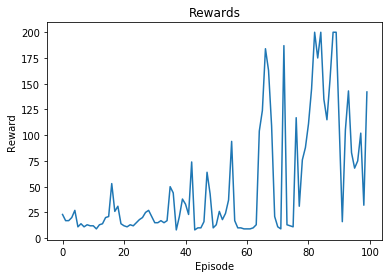

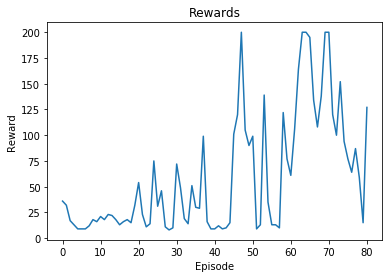

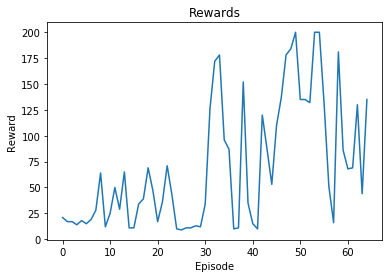

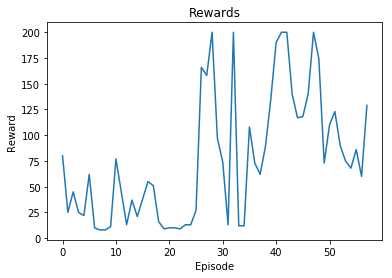

In [42]:
for i in range(len(plot_list)):
    fig, ax = plt.subplots(1)
    ax.set_title("Rewards")
    ax.set_xlabel("Episode")
    ax.set_ylabel("Reward")
    ax.plot(plot_list[i])

# Method for testing our parameters
## especially our learning rate

In [7]:
def test(test_episodes): 
    
    tf.reset_default_graph()

    #initialize variables to perform testing steps
    env = gym.make('CartPole-v0')
    
    global_network = AC_Network(network_building_function, 'global', None)
    
    reward_list = []
    
    saver = tf.train.Saver()

    with tf.Session() as sess:
        
        #get stored variable values to test
        saver.restore(sess, "./model.ckpt")
        
        for _ in range(test_episodes):

            observation = env.reset().reshape((1,4))
            d = False
            reward_sum = 0
            while not d:

                #perform muve according to our trained network
                action_prob = sess.run(global_network.policy, feed_dict = {global_network.drive : observation})
                action = np.random.choice(action_prob.shape[1],1,p = action_prob[0])[0]

                observation, reward, d, _ = env.step(action)

                observation = observation.reshape((1,4))

                reward_sum += reward
            
            reward_list.append(reward_sum)
    #return mean of all the rewards gained while testing the parameters
    return np.mean(reward_list)

    
    

# Experiment cell

In here we tested different learning rates with or without a decaying learning rate

In [34]:
#how many experiments and how long each test pahse
experiments = 20
test_episodes = 100

#variables needed for our learning rate 
decay_steps = 100
decay_rate = 1
learning_rates = np.logspace(-10, -1, 10)

# parameters needed for our network
gamma = .99
max_counter = 400 #number of episodes of every single worker
max_buffer_length = 10
network_building_function = cartpoleNetwork
env_name = 'CartPole-v0'

means = []
stds = []
worker_means = []
worker_std =[]
for num_worker in range(1,4):
    means = []
    stds = []
    for learning_rate in learning_rates:
        experiment_list = []
        for _ in range(experiments):
            train_A3C(env_name, network_building_function,
                      gamma, max_counter, max_buffer_length, learning_rate, decay_steps, decay_rate, num_worker)
            experiment_list.append(test(test_episodes))

        means.append(np.mean(experiment_list))
        stds.append(np.std(experiment_list)/ np.sqrt(experiments))
    worker_means.append(means)
    worker_std.append(stds)


Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
17
19
39
45
37
14
25
11
13
73
18
16
39
28
16
28
31
18
16
19
11
13
21
36
40
17
22
58
113
48
28
35
51
19
30
37
42
82
51
26
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
27
16
14
10
27
17
13
9
22
26
16
12
21
33
21
14
16
22
29
24
29
17
23
14
17
10
48
22
21
16
29
19
10
51
17
16
19
13
19
26
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit d

13
12
14
9
13
14
23
25
26
15
12
11
18
16
10
24
12
11
16
19
11
18
25
27
68
10
13
12
24
12
21
25
21
9
29
15
72
17
18
30
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
24
41
19
9
42
12
19
18
93
14
15
12
40
58
23
34
13
19
16
30
15
13
78
42
19
25
14
24
10
94
46
21
20
26
16
16
17
12
25
54
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype a

14
11
31
25
12
20
14
70
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
65
17
21
38
30
17
28
14
60
30
39
88
43
56
45
12
56
56
41
80
18
17
21
27
43
45
53
25
61
43
47
47
14
33
41
96
70
13
58
27
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:

Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
69
32
20
36
74
86
25
35
34
39
21
17
24
41
50
37
31
32
29
20
29
19
24
26
25
48
37
24
45
36
42
46
26
20
27
39
24
22
15
49
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
10
22
12
25
23
52
37
55
60
26
76
19
29
41
66
33
16
61
13
20
65
33
34
46
16
14
23
25
19
58
36
15
45
28
17
41
113
62
132
18
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit

21
10
16
15
15
18
13
18
31
53
19
26
17
11
15
13
37
25
9
17
18
15
16
13
14
13
22
17
12
28
14
13
15
27
16
31
16
12
10
16
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
54
58
18
18
110
18
19
78
70
28
21
50
61
29
24
63
23
44
13
105
34
40
23
47
13
35
15
14
44
31
48
21
19
15
59
57
19
112
43
56
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dt

9
17
14
19
12
11
17
25
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
14
26
30
29
24
12
19
41
20
11
14
12
58
38
24
39
53
24
32
41
25
25
20
11
36
9
23
9
14
19
42
13
17
40
48
14
24
57
19
22
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?,

Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
17
19
20
17
26
13
16
17
25
11
37
27
17
33
29
24
19
19
27
26
25
13
30
26
22
18
19
17
40
18
15
65
26
43
34
30
35
19
16
42
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
10
41
31
30
27
21
13
26
11
10
23
33
16
16
14
12
28
21
20
31
16
14
14
23
17
31
17
35
28
17
11
33
24
11
11
26
32
10
15
27
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit d

12
16
71
46
22
16
21
25
16
12
60
23
13
25
28
22
16
20
20
18
15
16
14
22
23
18
21
15
22
23
34
18
47
24
38
16
9
16
40
27
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
46
39
47
31
12
36
36
31
27
10
71
47
63
28
14
26
21
25
45
24
21
36
19
37
38
87
117
39
21
32
19
17
27
22
22
54
25
38
15
25
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtyp

11
13
20
11
19
10
20
32
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
31
16
22
19
42
41
23
18
13
16
21
24
12
27
15
13
13
16
24
35
20
24
42
25
31
12
15
12
12
12
12
25
9
48
14
12
13
10
11
24
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(

Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
13
35
61
79
91
33
15
67
94
24
27
64
38
49
89
45
20
63
35
77
42
57
75
14
29
44
29
36
44
25
48
39
44
33
37
59
105
27
56
68
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
16
22
27
11
18
14
42
20
23
14
45
26
60
22
18
21
24
63
10
37
15
13
26
22
17
63
15
27
12
11
14
16
29
12
10
62
24
20
23
14
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit 

14
16
40
25
22
12
18
14
25
14
24
19
41
18
107
23
22
18
12
47
22
37
56
33
20
12
21
21
24
21
17
37
25
19
22
22
25
77
26
15
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
21
25
11
12
13
24
16
33
11
12
21
13
32
12
12
25
18
15
11
28
14
28
28
20
15
16
23
26
19
16
12
9
20
15
27
21
17
18
16
10
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtyp

34
26
18
22
57
96
16
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
41
42
11
28
20
13
28
20
11
11
24
21
11
30
16
13
14
17
8
15
13
14
18
21
42
18
15
42
12
20
18
14
23
17
34
27
66
12
54
30
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 

Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
17
13
15
11
12
13
10
25
36
11
23
54
19
24
20
12
52
12
47
54
30
26
17
32
19
43
20
22
37
64
30
16
93
17
109
25
46
11
17
17
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
32
51
21
13
20
31
17
18
26
18
29
19
20
50
44
34
79
43
31
41
28
19
27
20
43
35
32
59
17
45
18
42
19
19
42
36
19
25
25
21
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit 

13
17
9
10
14
52
19
13
13
32
168
12
200
12
112
92
105
131
39
72
60
49
96
131
161
87
20
123
60
98
10
9
10
9
10
10
9
9
10
8
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
37
26
10
15
22
45
20
27
11
13
75
67
114
30
92
46
37
29
70
51
15
84
76
14
124
64
130
11
10
42
13
10
74
42
166
165
67
60
96
200
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetec

15
43
12
23
45
27
14
16
12
9
16
32
24
10
19
9
18
16
17
11
33
24
12
12
9
32
18
11
11
17
9
10
16
11
11
23
8
16
45
21
8
12
14
30
12
11
27
14
10
12
11
14
12
16
13
10
14
14
24
14
16
19
12
21
14
10
11
16
70
15
23
20
54
21
14
18
22
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
14
10
16
13
11
12
14
11
9
12
13
13
15
15
16
11
10
10
12
10
12
12
21
11
17
10
12
12
9
20
9
10
9
11
11
28
11
14
9
13
9
10
15
9
13
19
9
8
9
9
16
11
18
12
10
10
19
11
13
9
12


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
13
16
19
27
47
15
9
35
34
12
18
21
14
15
28
47
23
21
13
12
34
9
11
10
23
15
22
11
12
18
10
15
46
16
22
18
17
12
14
18
23
16
11
24
11
22
18
25
20
29
13
13
9
14
14
14
12
12
21
27
14
12
30
18
13
18
32
10
14
15
17
22
19
14
26
18
15
21
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
32


INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
12
16
22
9
16
16
22
16
36
8
23
21
11
10
25
18
21
11
16
14
10
10
21
10
9
13
28
19
12
16
12
15
12
9
17
21
17
11
15
21
12
14
13
14
9
14
26
18
9
19
13
15
14
22
11
10
10
18
10
9
14
16
11
11
10
11
10
10
13
18
12
14
9
9
24
19
16
10
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'nu

10
13
9
17
15
14
13
37
11
11
35
15
16
17
16
12
29
14
17
12
33
14
24
13
26
16
10
28
10
9
16
41
21
12
15
16
9
26
19
2912

20
20
18
13
12
12
50
28
41
12
66
16
21
14
32
13
14
11
18
19
30
23
14
13
18
11
12
11
23
14
21
22
20
11
17
23
24
12
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
9
14
10
14
8
10
10
8
9
11
13
28
10
10
12
13
12
10
8
10
11
10
13
14
16
9
9
10
13
10
12
12
9
10
13
10
18
15
12
17
11
17
10
11
9
16
12
11
11
11
9
17
13
9
11
12
10
17

Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
38
16
10
27
12
14
11
31
15
15
21
14
11
18
14
25
9
16
13
27
18
9
14
19
13
21
18
8
10
12
23
19
16
13
17
13
11
15
18
20
9
21
20
38
16
43
26
12
10
11
12
14
40
15
22
13
46
20
13
20
27
18
10
8
13
12
14
16
15
28
12
35
21
16
10
14
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Lay

35
68
18
40
19
30
44
33
19
40
13
25
73
37
36
43
26
19
17
19
15
18
53
47
48
47
73
36
24
31
26
72
35
77
21
84
24
33
39
23
27
16
52
31
73
46
44
46
32
27
40
9
59
27
27
80
58
21
16
52
12
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
23
12
21
30
9
11
14
18
24
11
14
12
20
48
58
11
19
8
17
12
9
27
11
10
35
28
47
12
37
22
37
47
10
19
20
31
32
19
21
9
9
18
19
14
30
24
11
21
19
11
23
10
41
13
11
17
20
13
13
9
10
13
16
14
10
31
41
14
24
14
11
21
17
3

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
12
22
15
12
18
11
34
24
17
12
12
36
15
14
24
13
18
20
15
25
15
9
19
32
9
30
17
10
15
18
13
19
26
14
12
15
11
23
13
23
10
17
16
9
14
14
16
15
9
35
28
22
19
16
36
25
14
17
34
13
16
26
10
21
14
10
30
14
22
17
13
13
11
22
13
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
9
11
24
12
15

Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
22
23
56
61
23
21
54
26
15
30
26
13
39
28
49
29
16
14
23
26
43
54
11
31
32
18
61
19
42
29
24
32
26
20
45
17
27
30
42
33
37
27
22
33
14
14
26
44
45
44
48
17
11
37
37
21
62
58
50
31
23
23
21
20
39
43
24
15
24
42
11
33
14
22
20
23
23
24
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


31
58
50
56
103
131
39
39
106
68
17
35
40
101
44
45
64
67
72
20
48
36
49
28
69
150
23
77
111
20
37
121
25
18
103
63
105
48
27
52
130
112
43
25
45
53
49
66
105
22
61
30
31
31
41
78
60
116
93
27
58
130
28
107
44
68
31
73
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
12
22
11
26
26
10
46
25
17
16
13
47
19
22
28
27
22
17
10
12
20
26
31
15
12
19
17
32
31
14
24
24
14
40
18
19
19
16
26
10
11
60
11
33
16
48
10
19
12
16
18
20
26
15
25
21
22
21
12


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
52
13
34
13
24
19
31
49
39
29
39
17
22
40
22
11
13
13
27
12
27
30
19
106
16
23
26
15
12
19
24
68
17
17
12
31
11
22
17
10
12
22
19
12
52
31
12
13
47
19
18
13
28
16
12
15
17
21
37
19
24
28
13
23
41
30
36
13
31
17
16
14
15
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
23
9
22
24
26


Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
21
47
37
19
73
38
26
16
13
10
16
27
11
25
36
58
12
12
12
13
53
10
12
9
12
15
35
16
33
11
32
28
17
11
17
17
37
41
14
14
9
14
27
12
33
13
20
26
30
11
13
15
24
30
47
31
21
12
21
21
34
25
17
11
21
25
14
34
15
21
21
26
10
15
16
9
14
14
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
For

23
101
80
26
89
47
13
100
16
25
51
87
30
43
60
53
122
67
25
23
41
54
68
70
38
35
37
22
50
10
74
23
31
81
39
22
14
16
35
44
14
66
46
44
110
91
47
48
25
70
18
37
112
13
13
83
52
29
65
21
35
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
41
51
15
31
53
20
22
15
34
29
33
41
39
27
22
17
11
27
12
16
31
18
90
50
30
22
16
12
34
46
23
20
15
28
55
27
27
26
17
36
23
16
43
27
29
28
18
15
22
9
25
26
34
42
15
173
17
22
27
26
44
53
29
10
19
45
54
47
26
2

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
8
11
14
10
9
20
15
11
11
15
11
11
9
15
14
14
10
13
9
14
12
11
16
14
18
10
12
15
12
10
10
11
10
11
16
10
9
11
15
21
9
14
10
8
10
10
9
9
10
13
13
11
15
15
10
9
12
13
9
9
12
10
11
15
9
12
10
10
10
9
9
10
10
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
23
53
25
35
10
45
18
21
23
58


Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
53
10
20
34
39
33
11
35
46
16
18
24
16
33
18
23
19
27
29
14
31
37
30
41
22
25
19
35
18
70
17
34
14
63
32
17
19
23
46
33
22
21
38
20
97
59
13
13
22
10
14
34
17
14
19
17
24
27
14
40
28
31
12
17
17
13
48
11
37
31
14
56
32
11
34
32
84
32
32
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtyp

11
18
10
17
15
15
11
9
12
11
13
11
10
12
11
10
10
11
10
14
12
14
10
15
10
10
17
16
9
9
11
10
11
14
12
10
8
10
10
20
14
10
11
9
12
10
19
18
16
10
12
9
9
10
10
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
30
32
43
38
16
58
23
28
15
32
51
25
46
31
57
33
38
30
60
30
39
36
51
21
68
32
56
83
43
16
42
23
19
42
50
47
13
31
36
57
29
38
26
30
27
50
45
41
78
21
28
68
37
25
22
20
42
41
21
29
42
38
41
11
29
41
46
27
38
17
59
101
36
39
47
40
66
65
93


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
30
25
21
19
13
32
17
31
18
18
13
16
22
19
26
22
15
14
23
39
27
27
11
26
19
23
27
14
10
25
45
27
18
28
13
19
13
12
10
18
17
12
19
13
20
44
17
31
21
18
22
30
16
17
38
27
16
32
18
30
96
15
45
15
26
28
34
26
24
26
11
30
32
50
17
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
30
13
13


Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
33
28
25
26
15
24
21
12
32
31
41
12
38
14
38
73
17
19
24
60
14
13
14
13
16
11
18
42
18
45
20
32
64
41
48
27
15
70
103
17
54
68
17
28
60
31
60
21
31
19
61
14
31
100
15
93
40
10
14
37
78
15
36
19
16
30
22
16
69
39
19
62
10
52
141
20
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
For

27
16
20
27
16
19
23
42
26
20
24
16
34
24
33
54
20
3128

16
29
15
56
16
24
26
13
17
24
27
96
12
20
34
15
40
22
39
19
28
24
14
39
115
25
21
29
36
39
29
35
14
14
33
45
49
24
31
39
36
13
41
37
39
62
48
14
20
115
16
52
21
109
12
49
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
58
101
27
25
22
14
20
31
20
35
31
35
18
16
19
44
19
30
41
13
19
17
17
22
67
13
31
16
21
38
40
17
14
27
48
20
13
57
12
64
98
24
96
23
89
21
42
15
28
91
17
23
16
12
59
59

Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
24
20
26
14
15
50
33
12
14
19
39
40
25
27
81
15
23
21
37
13
17
22
48
40
21
17
51
16
35
14
74
16
29
26
34
19
106
15
22
25
14
61
30
28
12
60
15
31
11
46
120
18
33
27
37
35
51
12
59
31
36
54
101
20
39
74
43
35
78
54
24
24
15
25
44
14
140
21
71
158
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide expli

37
13
42
13
14
16
57
86
97
15
20
13
1315

9
161
15
38
19
18
48
14
10
14
20
50
19
152
86
12
12
12
21
15
99
102
86
20
126
16
41
27
142
99
155
173
40
11
61
25
10
10
10
10
9
10
10
9
10
9
9
9
10
8
9
9
10
8
10
11
200
139
200
200
200
200
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
13
10
13
13
50
57
53
9
11
177
15
19
69
10
15
155
29
200
14
63
47
80
67
33
13
10
57
11
9
26
14
26
68
15
27
16
103
10
10
19
16
101
12
25
85
32
26
115
200
13
59
22
200


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
13
9
9
10
9
9
8
10
10
10
8
10
10
11
9
11
9
10
9
9
10
9
10
9
10
8
9
10
8
10
9
10
10
9
9
10
10
9
9
9
9
9
8
10
9
9
10
10
8
10
8
9
9
9
9
10
9
8
8
10
10
10
10
10
11
9
9
10
9
9
10
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
9
8
10
8
9
10
8
10
10
10
10
10
10
8
11
9
9
10
9
9
10
10
9
9


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
15
11
14
12
10
11
10
11
21
12
18
21
11
12
21
14
24
9
15
12
12
19
9
14
10
11
16
16
20
13
10
8
12
12
14
25
17
10
15
9
911

17
10
12
9
15
14
17
12
8
17
10
19
11
17
10
15
14
15
11
12
15
15
11
15
11
10
18
19
12
22
11
12
21
17
25
18
33
13
15
10
10
14
19
9
17
13
16
11
14
11
10
15
12
11
23
24
15
11
16
34
48
12
14
9
18
19
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provid

14
11
62
24
12
31
12
23
37
20
22
52
18
42
25
24
25
18
17
14
26
20
36
65
57
18
16
15
38
21
26
27
43
13
47
19
31
20
15
21
33
15
23
14
26
52
13
12
15
29
10
14
15
17
24
31
26
55
58
29
18
33
14
15
18
16
26
41
10
11
17
21
30
12
28
45
3022

16
50
18
14
16
27
21
18
20
31
11
44
16
28
9
53
18
40
15
26
14
24
11
32
21
23
31
33
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please prov

13
32
38
20
12
17
12
14
13
13
53
18
19
32
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
52
34
15
80
52
14
17
35
24
18
29
2913

130
12
29
20
98
22
21
54
18
38
20
54
12
71
11
14
18
27
11
19
29
19
18
32
36
26
48
69
20
33
29
26
14
31
31
18
43
22
27
48
31
77
33
28
59
32
26
43
69
16
25

Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
11
14
12
16
14
13
19
17
21
12
29
14
12
21
11
10
19
9
9
17
10
13
15
40
17
12
24
8
13
9
17
15
12
15
26
13
16
17
15
15
18
24
19
10
14
21
18
16
14
11
11
29
10
13
12
10
10
11
12
18
18
16
13
14
15
11
19
22
16
12
13
12
14
18
25
10
35
18
18
18
12
15
61
18
13
12
35
13
9
9
14
20
17
9
10
14
15
13
20
15
12
15
11
23
16
11
16
16
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
12
35
13
20
21
19
27
21
11
18
9
22
47
13
10
12
22
25
11
13
38
10
24
14
13
16
17
23
17
13
11
11
26
13
11
15
34
11
8
45
10
15
13
18
14
10
17
15
27
15
19
19
16
18
18
18
11
11
14
10
22
9
16
35
9
17
12
37
13
11
12
22
20
22
10
14
15
13
15
11
12
14
19
22
12
10
16
51
21
11
14
14
11
13
17
14
12
10
10
9
13
15
17
13
18
25
9
10
12
24
41
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. P

10
16
11
21
22
20
10
11
10
15
11
13
17
20
12
16
19
10
13
11
15
26
14
13
19
11
14
14
23
11
14
15
20
22
11
14
13
12
16
11
17
10
14
16
15
34
21
9
13
18
35
15
20
15
18
15
12
10
13
17
11
10
33
20
10
9
13
10
18
9
10
13
18
11
10
18
14
23
13
13
13
27
15
15
15
12
14
17
12
14
22
13
16
16
11
16
17
15
15
15
12
16
29
11
11
22
16
11
12
27
14
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>

13
19
16
31
32
23
15
14
17
12
18
24
21
16
19
12
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
31
16
14
28
15
15
24
17
49
20
33
24
16
34
14
12
16
25
19
26
36
28
17
14
13
15
29
14
21
12
17
15
17
35
24
10
10
15
14
21
15
16
17
18
10
10
37
11
21
26
20
16
13
37
40
26
16
12
16
16
28
18


Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
48
31
43
57
20
28
15
19
21
16
37
16
17
10
22
48
28
21
35
31
13
22
16
27
29
14
15
22
14
14
21
12
39
14
21
35
18
40
24
17
21
18
21
57
20
11
13
19
15
21
12
15
66
12
13
29
13
16
20
48
12
42
13
36
28
17
20
26
12
28
50
27
17
33
22
20
39
37
19
22
13
16
13
14
21
35
16
48
19
33
92
28
15
33
18
13
33
14
17
18
19
21
14
26
26
16
21
29
14
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forw

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
10
8
16
12
13
11
11
14
22
22
11
9
17
10
15
11
12
15
16
12
14
16
18
10
13
11
8
15
9
11
11
11
15
11
10
13
14
9
10
8
11
16
8
16
10
14
11
16
17
10
17
12
16
18
12
25
19
12
13
14
14
13
14
13
23
13
14
12
13
10
11
15
13
27
16
12
12
16
9
14
9
16
10
14
8
11
13
12
11
10
14
12
18
9
12
15
32
23
9
11
9
9
26
9
9
18
13
15
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide expli

11
19
16
11
9
16
13
12
10
14
10
10
14
17
12
15
12
12
21
119

10
8
14
10
9
10
11
21
19
16
16
16
10
17
13
12
10
16
11
14
10
9
12
13
15
9
14
20
9
13
12
13
12
12
18
10
11
11
12
10
11
11
10
23
10
9
22
15
9
11
12
16
16
23
10
18
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
15
12
38
20


Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
26
18
48
15
27
13
20
19
21
15
21
13
27
49
21
17
13
31
46
11
30
14
30
13
16
31
11
12
15
23
22
16
34
24
25
39
19
27
18
56
15
18
28
29
31
25
22
10
19
15
13
39
19
17
13
23
41
29
21
13
29
19
26
14
23
30
26
9
34
17
8
39
12
26
31
19
13
11
20
21
14
1522

32
14
21
27
19
19
23
16
23
22
12
19
9
13
12
38
20
24
13
65
13
20
34
10
12
13
19
28
17
19
23
13
44
17
17
18
WARN: gym.spaces.Box 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
23
18
10
32
11
11
24
10
23
21
16
44
16
18
14
26
17
17
23
34
9
13
12
23
13
10
49
13
15
20
30
27
16
26
26
20
9
16
21
17
13
15
25
24
13
12
10
36
16
28
14
13
17
19
19
16
28
18
18
23
22
15
15
25
24
12
29
18
12
10
16
16
12
13
25
17
39
13
14
12
12
10
44
16
8
20
13
43
11
31
12
19
24
16
20
16
16
67
14
25
34
27
22
15
23
17
33
2119

10
25
52
21
14
13
27
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class '

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
10
12
15
20
13
1022

13
14
29
12
14
23
23
15
11
19
16
12
14
10
30
20
10
16
26
12
21
27
18
22
21
10
9
11
13
16
13
14
25
9
26
12
11
17
12
16
19
21
12
12
16
13
27
26
18
38
30
15
20
21
14
13
15
20
12
18
15
12
14
26
24
13
19
10
15
19
26
15
17
20
10
18
9
10
16
12
14
23
21
9
31
13
38
21
12
9
11
37
11
14
11
11
13
12
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide exp

39
40
26
22
30
41
36
44
35
30
41
21
22
36
20
13
23
47
26
23
41
31
27
9
32
30
15
19
22
19
21
15
29
68
48
21
29
24
13
19
33
33
20
39
10
26
20
20
39
38
24
37
13
25
25
34
30
30
23
24
19
19
13
48
31
26
44
18
26
19
33
28
18
23
1911

45
29
42
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8

12
18
14
11
52
17
11
11
16
12
39
12
12
30
26
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
20
11
16
19
9
10
25
22
12
18
16
12
18
19
20
12
18
28
9
14
12
12
11
16
13
42
29
18
17
13
12
10
39
11
17
12
13
21
17
15
10
16
26
12
9
13
18
24
15
16
20
11
12
13
15
10
14
11
22
12
28
14
12
15


Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
10
9
11
9
11
10
16
10
9
11
9
11
11
11
13
11
10
8
16
9
12
10
12
10
16
13
13
9
9
13
10
9
11
15
17
9
11
13
12
8
11
19
9
25
10
11
10
17
10
10
8
9
11
9
12
10
8
12
9
13
17
12
12
9
10
11
10
12
10
11
9
13
10
10
10
1510

12
12
9
10
10
9
11
19
11
11
12
10
11
10
16
11
10
9
14
12
14
13
13
12
10
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
11
10
13
18
25
1810

12
9
15
10
10
18
16
13
28
9
10
16
13
31
15
18
15
9
12
18
9
22
22
14
11
14
20
9
15
10
13
15
10
13
10
21
14
10
15
11
13
11
20
11
10
11
13
9
10
18
18
12
10
18
14
14
10
17
13
9
13
8
9
19
11
13
12
20
13
16
11
24
9
9
33
13
9
12
12
12
21
16
27
11
12
17
13
13
12
12
10
10
10
45
10
11
10
13
17
11
35
17
11
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please pro

64
50
11
82
75
12
16
38
17
34
54
40
11
22
21
14
39
29
31
25
22
26
21
24
17
20
42
20
61
24
31
31
86
10
24
49
34
16
32
26
72
33
25
14
14
12
41
40
31
27
55
51
21
20
36
37
85
35
41
33
16
32
12
21
12
10
43
22
11
36
36
67
36
46
47
76
42
29
16
33
76
21
14
24
41
22
22
38
21
44
23
17
31
90
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(

12
16
58
16
22
23
10
16
20
11
11
10
25
22
14
31
12
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
12
29
25
11
17
14
23
11
14
20
16
16
23
20
13
12
9
17
15
10
19
24
9
13
11
12
13
32
13
17
15
20
9
21
18
14
13
18
31
33
11
19
22
15
11
13
11
10
16
11
10
29
14
20
30
18
10
14
30
13
14
10


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
26
116
52
77
30
55
29
53
48
38
31
31
21
51
12
33
29
51
64
84
23
18
12
51
18
24
30
40
21
27
28
17
19
17
24
15
13
71
46
10
29
30
23
65
26
13
25
21
21
24
21
64
60
27
11
31
63
71
26
28
18
26
11
27
63
33
46
26
12
32
65
11
16
35
25
19
16
21
23
35
56
23
30
24
34
22
31
28
37
37
17
13
13
18
20
85
39
20
40
26
21
18
34
17
28
46
37
15
14
12
17
14
2925

17
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 

19
10
13
9
14
12
15
14
32
15
19
14
18
10
11
16
13
27
20
21
11
12
38
17
24
31
10
23
12
13
22
26
9
22
21
11
13
14
16
18
20
12
11
16
11
26
17
25
12
27
25
17
15
26
26
22
38
19
32
11
29
58
31
20
13
27
31
15
29
13
17
13
40
18
17
11
43
33
29
46
38
26
26
45
45
36
31
50
48
27
19
28
28
21
21
34
12
18
12
13
18
26
16
17
60
37
17
38
38
16
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. 

11
30
21
21
19
78
42
45
28
19
12
31
16
16
30
31
57
39
25
32
18
28
17
31
53
72
18
21
16
14
52
40
31
26
25
36
12
50
33
17
16
23
26
30
15
30
31
20
18
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
19
22
27
9
19
11
10
15
36
16
20
26
18
20
8
14
12
11
23
1912

8
13
19
21
17
18
50
12
32


Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
21
26
22
12
27
22
19
46
35
17
25
21
21
11
2164

18
24
16
65
1917

16
14
53
30
29
13
48
18
25
14
15
80
11
34
11
12
15
38
14
36
17
23
2614

18
34
16
21
18
30
67
18
57
3456

25
28
18
34
10
21
17
45
49
41
85
17
77
71
40
119
20
18
22
101
72
61
73
51
15
29
36
19
16
145
142
42
107
14
41
15
22
82
34
18
53
26
23
89
172
15
24
27
90
120
99
47
78
15
21
16
200
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Fo

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
12
25
23
50
11
16
19
12
11
13
45
19
64
41
20
41
13
19
15
36
53
34
12
48
15
14
12
62
39
23
29
29
30
30
19
57
64
22
47
13
37
19
14
49
82
33
29
15
16
28
34
54
37
121
31
125
24
53
25
28
92
21
17
51
18
19
14
42
42
32
133
24
122
32
59
44
26
54
41
26
49
26
65
54
40
78
19
60
133
24
20
86
122
30
36
43
165
18
50
150
75
28
74
16
54
21
20
118
103
11
15
37
193
30
24
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
37
22
17
29
11
29
30
24
29
41
15
22
77
19
13
22
14
25
21
26
21
52
138
60
26
17
12
15
31
18
17
31
22
19
67
14
20
80
16
69
11
17
52
12
22
21
21
30
43
20
33
33
24
35
38
27
39
31
19
123
14
113
19
16
73
16
22
44
83
21
38
15
24
142
12
26
6920

24
34
30
135
26
22
28
27
124
45
64
93
19
27
98
27
33
103
36
41
62
18
59
66
17
23
84
91
63
24
143
100
20
108
28
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <cla

9
8
10
10
9
10
9
10
10
10
9
10
10
9
10
9
9
9
10
9
9
9
10
9
10
9
10
8
9
10
9
10
10
9
9
10
9
8
10
9
9
10
99

10
9
9
9
10
9
9
9
9
8
10
10
9
10
8
10
10
9
10
10
9
10
8
10
8
8
9
10
10
10
9
10
9
9
10
10
10
10
9
10
10
10
10
9
10
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
30
16
27
9
9


16
25
12
192
50
57
132
9
9
37
12
21
102
35
43
23
91
27
101
81
24
20
31
35
66
73
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
13
9
9
10
10
10
10
9
11
9
8
10
10
10
10
9
9
9
10
8
8
10
9
8
8
8
8
9
9
8
8
9
8
10
8
10
10
9
10
8
9
13
10
12
9
10
9
9
9
10
9
10
10
10
9
9
9
9
9
8
9
9
9
9
91

C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in less


9
9
11
10
9
10
9
9
10
8
9
10
9
8
10
8
11
10
9
10
9
9
8
9
10
9
9
11
9
9
11
9
10
10
10
10
9
10
10
8
8
10
10
10
9
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
INFO:tensorflow:Restoring parameters from ./model.ckpt


C:\Users\Jonas Kraasch\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in less


Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Forward-Layer:(?, 4)
Forward-Layer:(?, 8)
Forward-Layer:(?, 8)
38
25
15
16
33
19
49
16
65
17
22
12
11
21
92
28
10
13
12
20
42
13
11
64
9
56
25
35
81
55
9
34
13
22
12
54
9
62
14
22
19
19
45
64
64
128
120
170
29
18
11
49
10
11
11
32
200
14
19
26
8
12
53
12
12
10
12
43
36
36
28
200
200
83
95
36
16
15
54
29
33
35
28
86
16
31
35
32
70
71
13
13
69
28
92
98
97
101
100
16
111
110
104
100
75
91
138
152
143
111
100
96
87
72
65
103
120
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide ex

# Here you can see the results for the different threads
## starting with 1 thread to 3

10
10
10
10
10
10


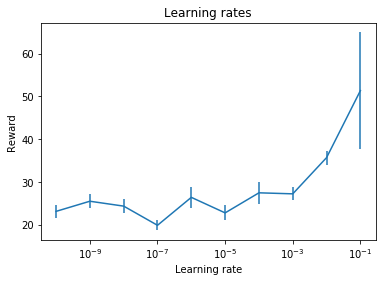

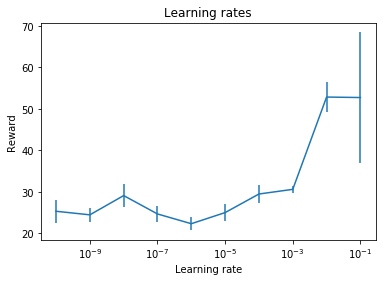

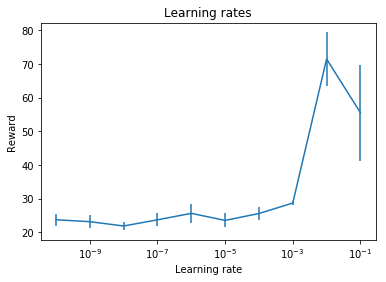

In [35]:
for i in range(0,3):
    mean = worker_means[i]
    std = worker_std[i]
    fig, ax = plt.subplots()
    ax.set_title("Learning rates")
    ax.set_xlabel("Learning rate")
    ax.set_ylabel("Reward")
    ax.errorbar(learning_rates[::], mean, yerr = std)
    ax.set_xscale("log", nonposx='clip')